# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [116]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.style.use('dark_background')
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [117]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [118]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Значения в массиве показывают вероятность отнесения к одному из классов (здесь они рандомно распределены).Также predict_proba возвращает именно вероятности, а не значения 0 и 1 по порогу 0.5 в отличие от predict

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [119]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


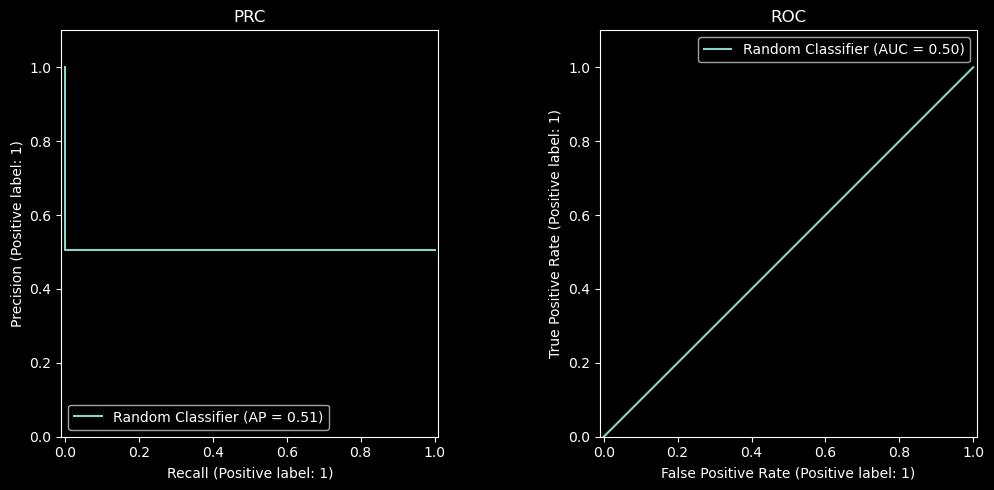

In [120]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')
plt.show()

In [121]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [122]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score

In [123]:
param_grid = {'C': np.logspace(-4, 2, 20)}
grid_search = GridSearchCV(LinearSVC(), param_grid, scoring='average_precision', cv=5)
grid_search.fit(X_train, y_train)

best_c = grid_search.best_params_['C']
print(f'Best C: {best_c}')
best_svc = grid_search.best_estimator_
print(f'AUC-PR: {grid_search.best_score_}')

Best C: 0.0001
AUC-PR: 0.8243879028237565


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVC (C=0.0001) metrics
AUC-PR: 0.8299
AUC-ROC: 0.8451


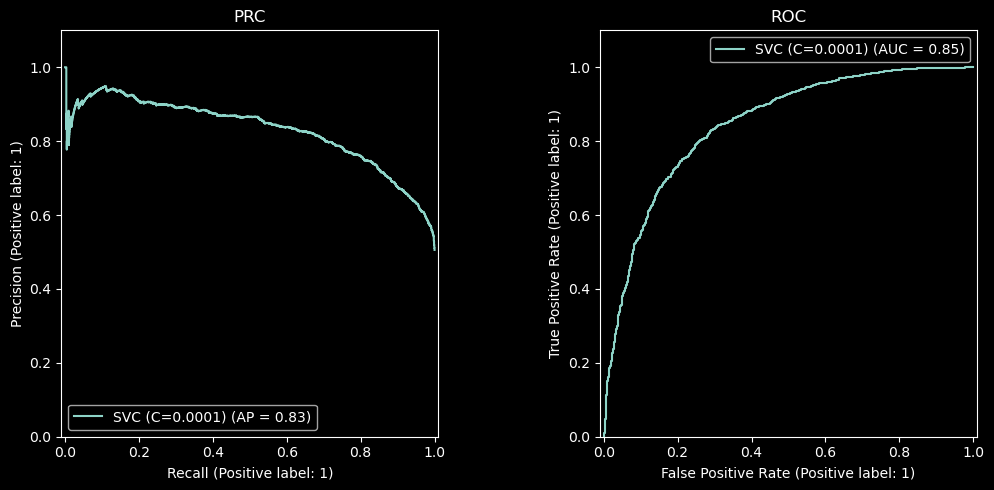

In [124]:
best_svc_pred = best_svc.decision_function(X_test)
depict_pr_roc(y_test, best_svc_pred, f'SVC (C={best_c})')
plt.show()
df_metrics.loc[f'SVC'] = [
    average_precision_score(y_test, best_svc_pred),
    roc_auc_score(y_test, best_svc_pred),
    best_c,
]

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

1) При увеличении порога растет ROC и падает PRC
2) Кривые достаточно монотонны

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [125]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0000
SVC,0.829864,0.845116,0.0001


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [126]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': np.logspace(-4, 2, 20)}
grid_search_lg = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, scoring='average_precision', cv=5)
grid_search_lg.fit(X_train, y_train)

best_c_lg = grid_search_lg.best_params_['C']
print(f'Best C: {best_c_lg}')
best_lg= grid_search_lg.best_estimator_
print(f'AUC-PR: {grid_search_lg.best_score_}')

Best C: 0.00042813323987193956
AUC-PR: 0.8287796825508158


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Logistic Regression metrics
AUC-PR: 0.8348
AUC-ROC: 0.8428


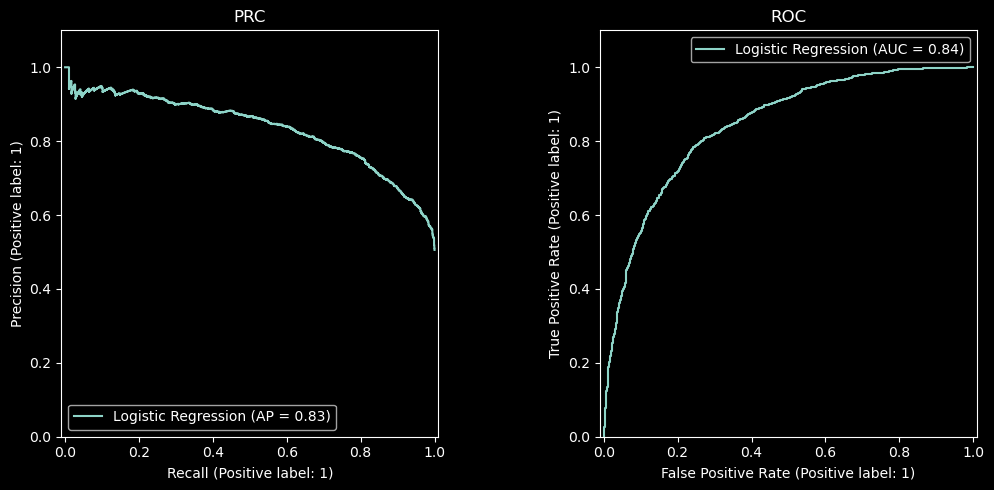

In [127]:
best_lg_pred = best_lg.decision_function(X_test)
depict_pr_roc(y_test, best_lg_pred, 'Logistic Regression')
plt.show()
df_metrics.loc['Logistic Regression'] = [
    average_precision_score(y_test, best_lg_pred),
    roc_auc_score(y_test, best_lg_pred),
    best_c_lg,
]

In [128]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
SVC,0.829864,0.845116,0.000100
Logistic Regression,0.834832,0.842763,0.000428


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** По качеству logreg и svm отличаются не сильно, где-то выще auc_pr, где-то выше roc_auc_score	

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [129]:
from sklearn.svm import SVC

In [130]:
np.random.seed(42)
X, y = make_classification(n_samples=7100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_svm = SVC(kernel='linear')

param_grid = {'C': np.logspace(-4, 2, 20)}
search = GridSearchCV(model_svm, param_grid, scoring='average_precision', cv=5)
search.fit(X_train, y_train)

best_c = search.best_params_['C']
print(f'Best C: {best_c}')
best_svc = search.best_estimator_
print(f'AUC-PR: {search.best_score_}')

Best C: 0.14384498882876628
AUC-PR: 0.9504110346494956


In [131]:
model_svm.set_params(**search.best_params_)
model_svm.fit(X_train, y_train)

SVC(C=0.14384498882876628, kernel='linear')

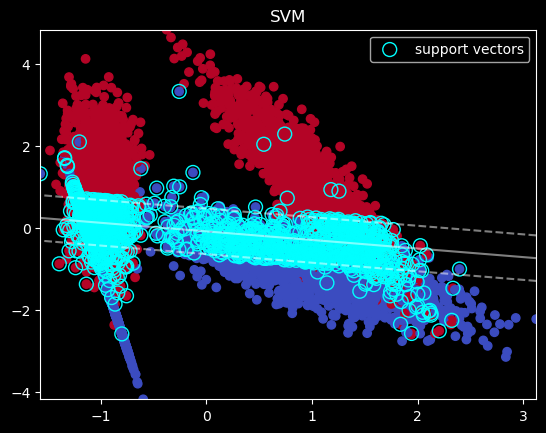

In [132]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='w', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=y, 
        cmap=plt.cm.coolwarm
    )

    # Отрисовали опорные векторы
    if plot_support:
        support_vectors = model.support_vectors_
        plt.scatter(
            support_vectors[:, 0], 
            support_vectors[:, 1], 
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="cyan",
            facecolors='none'
        )

    plt.title('SVM')
    plt.legend()

plot_svm_2D(X, y, model_svm)
plt.show()

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** как "опорные векторы" выделяются объекты из обучающей выборки, которые лежат наиболее близко к разделяющей гиперплоскости.  Они являются "опорными", так как определяют положение гиперплоскости. Если сдвинуть любой из опорных векторов, то разделяющая гиперплоскость также изменила бы своё положение.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [133]:
model_logreg = LogisticRegression(penalty='l2')

param_grid = {'C': np.logspace(-4, 2, 20)}
search_lg = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, scoring='average_precision', cv=5)
search_lg.fit(X_train, y_train)

best_c_lg = search_lg.best_params_['C']
print(f'Best C: {best_c_lg}')
best_lg= search_lg.best_estimator_
print(f'AUC-PR: {search_lg.best_score_}')

Best C: 5.455594781168514
AUC-PR: 0.9505686758646293


In [134]:
model_logreg.set_params(**search_lg.best_params_)
model_logreg.fit(X_train, y_train)

LogisticRegression(C=5.455594781168514)

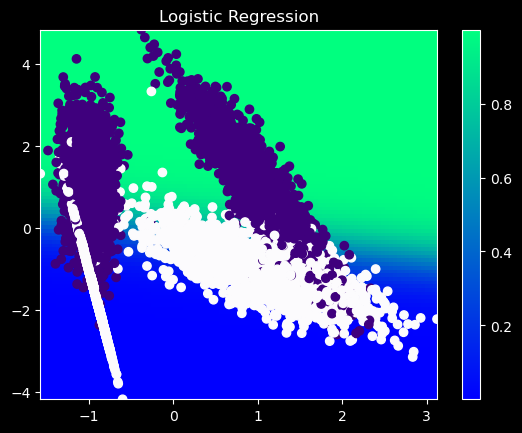

In [135]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        #cmap=plt.cm.PuOr_r
        cmap='winter'
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=y,
        cmap=plt.cm.Purples
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model_logreg)
plt.title('Logistic Regression')
plt.show()

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Это линия, которая разделяет объекты с вероятностью > 0.5 и < 0.5. Теоретически:

$$p(y=+1|x) = \dfrac{1}{1 + exp^{-(\sum_{0}^{n} w_i \cdot x_i)}} = 0.5 \Rightarrow 1 + exp^{-(\sum_{0}^{n} w_i \cdot x_i)} = 2 \Rightarrow exp^{-(\sum_{0}^{n} w_i \cdot x_i)} = 1 \Rightarrow -\left(\sum_{0}^{n} w_i \cdot x_i\right) = 0$$


#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [136]:
def plot_calibration_curve(y_test, preds, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)  
        bin_data = np.mean(y_test[(preds >= l) & (preds < r)] == 1)
        bin_real_ratios.append(bin_data)
    plt.plot(bin_middle_points, bin_real_ratios, label=label)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [137]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

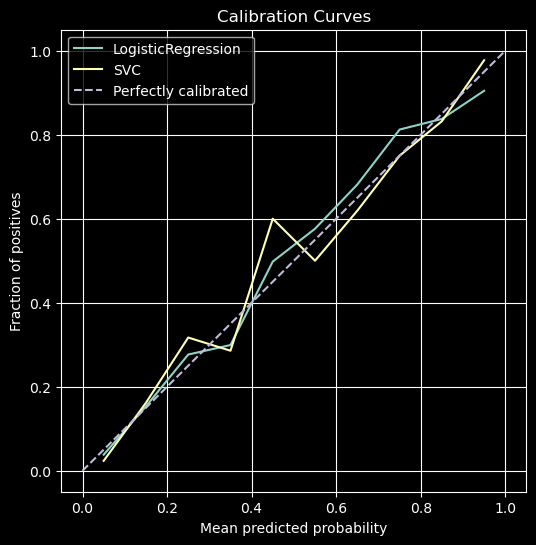

In [138]:
logreg = LogisticRegression(C=best_c_lg).fit(X_train, y_train)
svc = SVC(probability=True, C = best_c) 
svc.fit(X_train, y_train)
plt.figure(figsize=(6,6))
prob_logreg = logreg.predict_proba(X_test)[:, 1]
prob_svm = svc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, prob_logreg, 'LogisticRegression')
plot_calibration_curve(y_test, prob_svm, 'SVC')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.grid()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Кривая для логичестической регресии более монотонна и лучше откалибрована, чем для SVM, однако SVM проходит ближе к идеальной откаблированной модели. В целом, обе кривые достаточно неуверенные, но SVM слишком уверенная начиная с 0.4

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [139]:
from sklearn.metrics import log_loss, brier_score_loss

logloss_logreg = log_loss(y_test, prob_logreg)
brier_logreg = brier_score_loss(y_test, prob_logreg)

logloss_svm = log_loss(y_test, prob_svm)
brier_svm = brier_score_loss(y_test, prob_svm)

print(f'Logreg:\n logloss: {logloss_logreg} \n brier score: {brier_logreg}')
print(f'SVM:\n logloss: {logloss_svm} \n brier score: {brier_svm}')

Logreg:
 logloss: 0.48585489165191637 
 brier score: 0.158581767090838
SVM:
 logloss: 0.19040370635910867 
 brier score: 0.053151758711668814


Более низкие значения LogLoss и Brier Score показывают лучшее соответствие между предсказанными вероятностей и истинными значениями. В целом, LogLoss и Brier Score у SVM немного выше, чем у логистической регрессии

Изучите распределение ответов классификаторов при помощи гистограмм

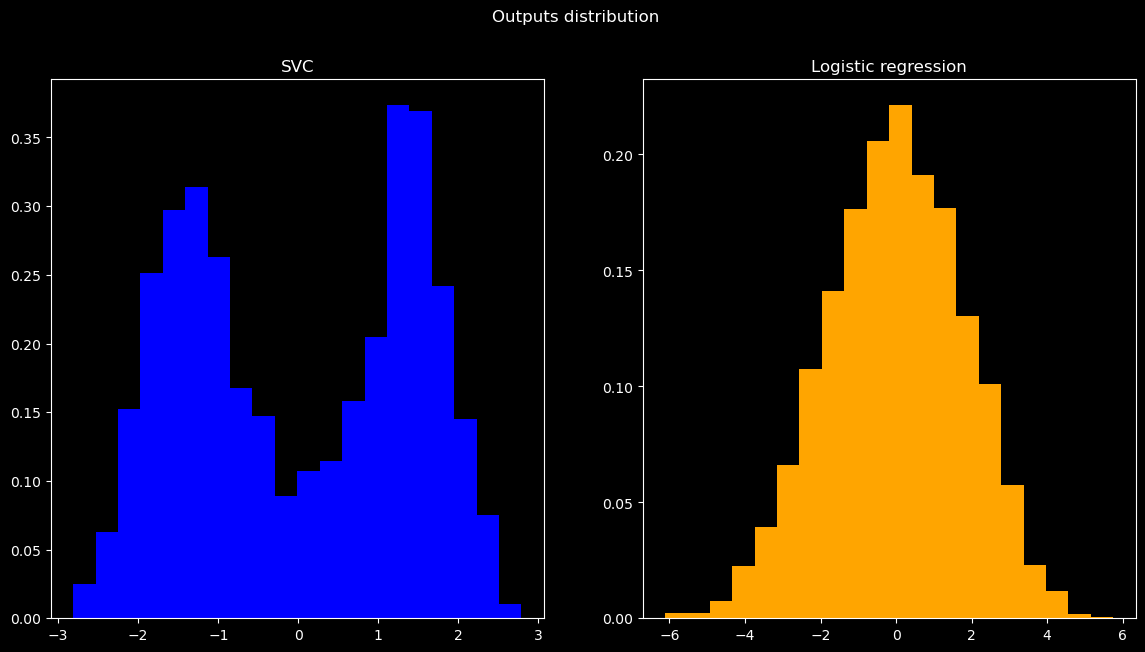

In [140]:
#код с семинара

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
svc_pred = svc.decision_function(X_test)
lr_pred = logreg.decision_function(X_test)
axs[0].hist(svc_pred, bins=20, color='blue', density='True')
plt.grid()
axs[1].hist(lr_pred, bins=20, color='orange', density='True')
plt.grid()
axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Для логистической регрессии распределение больше похоже на нормальное, в то время как распределение для SVM имеет две вершины, примерно сосредоточенные около 1 и -1. Это можно объяснить тем, что логичестическая регрессия более слабый классификатор (неуверенный), а SVM слишком уверенный классификатор

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [141]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

с_svc = CalibratedClassifierCV(svc, cv=3).fit(X_train, y_train)
с_svc_pred = с_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, с_svc_pred))

SVC ROC-AUC: 0.9762671738725553


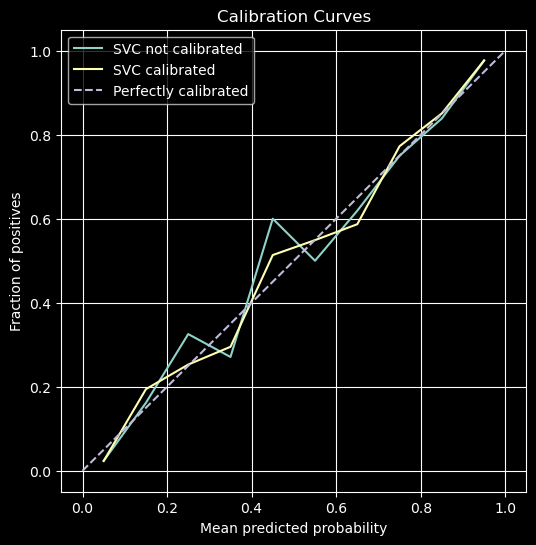

In [142]:
logreg = LogisticRegression(C=best_c_lg).fit(X_train, y_train)
svc = SVC(probability=True, C = best_c) 
svc.fit(X_train, y_train)
plt.figure(figsize=(6,6))
prob_logreg = logreg.predict_proba(X_test)[:, 1]
prob_svm = svc.predict_proba(X_test)[:, 1]
#plot_calibration_curve(y_test, prob_logreg, 'LogisticRegression')
plot_calibration_curve(y_test, prob_svm, 'SVC not calibrated')
plot_calibration_curve(y_test, с_svc_pred, 'SVC calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.legend()
plt.grid()
plt.show()

In [143]:
logloss_svm_c = log_loss(y_test, с_svc_pred)
brier_svm_c = brier_score_loss(y_test, с_svc_pred)

print(f'SVC calibrated:\n logloss: {logloss_svm_c} \n brier score: {brier_svm_c}')

SVC calibrated:
 logloss: 0.19357928776838268 
 brier score: 0.05545599665213739


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Калибровочная кривая стала заметно менее "угловой" и ближе к идеальной калибровке

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [144]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def platt_scaling(scores, labels, iters=1000, lr=0.01):
    n = len(scores)
    A = 0.0
    B = 0.0
    for _ in range(iters):
        dA = 0.0
        dB = 0.0
        for i in range(n):
            p = sigmoid(A * scores[i] + B)
            dA += (p - labels[i]) * scores[i] * p * (1 - p)
            dB += (p - labels[i]) * p * (1 - p)
        A -= lr * dA
        B -= lr * dB
    return A, B

def calibrate_platt(scores, A, B):
  return sigmoid(A * scores + B)

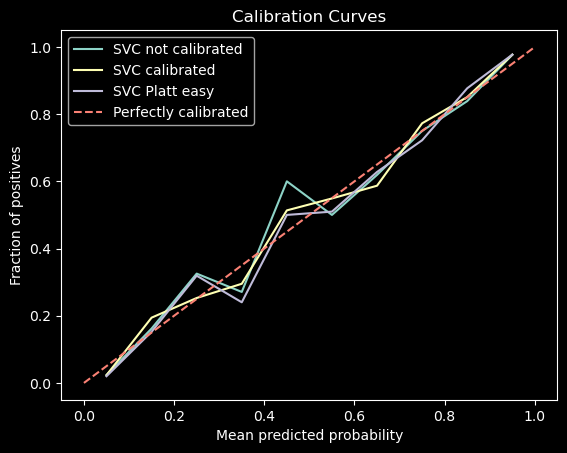

In [145]:
d_scores = svc.decision_function(X_test)
A, B = platt_scaling(d_scores, y_test)
calibrated = calibrate_platt(d_scores, A, B)

plot_calibration_curve(y_test, prob_svm, 'SVC not calibrated')
plot_calibration_curve(y_test, с_svc_pred, 'SVC calibrated')
plot_calibration_curve(y_test, calibrate_platt(d_scores, A, B), 'SVC Platt easy')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves")
plt.grid()
plt.legend()
plt.show()

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [146]:
#import kagglehub 

#path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [292]:
df_bikes = pd.read_csv('bike_buyers.csv')
num = ['Income', 'Children', 'Cars', 'Age', 'ID']
df_bikes.loc[:, ~df_bikes.columns.isin(num)] = df_bikes.loc[:, ~df_bikes.columns.isin(num)].fillna('undefined')

X = df_bikes.loc[:, ~df_bikes.columns.isin(['Purchased Bike'])]
y = (df_bikes['Purchased Bike'] == 'Yes').astype('int64')

# Разделим на категориальные признаки и числовые
X_numerical = X[['Income', 'Children', 'Cars', 'Age']]
X_categorical = X.loc[:, ~X.columns.isin(num)]

In [148]:
df_bikes

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,undefined,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


В начале поработаем только с категориальными признаками

In [293]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [244]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import time

pipeline = Pipeline(steps=[
  ('ohe_and_scale', OrdinalEncoder()),
  ('log', LogisticRegression())
])

start = time.perf_counter()
model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_train = model.predict_proba(X_train)[:, 1]
end = time.perf_counter()
print(f'Time spent: {end - start}')
print(f'auc_roc_test:{roc_auc_score(y_test, y_pred)}')
print(f'auc_roc_train:{roc_auc_score(y_train, y_pred_train)}')

Time spent: 0.02261820901185274
auc_roc_test:0.5925961538461538
auc_roc_train:0.6352035548212976


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [245]:
pipeline = Pipeline(steps=[
  ('ohe_and_scale', OneHotEncoder()),
  ('log', LogisticRegression())
])

start = time.perf_counter()
model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_train = model.predict_proba(X_train)[:, 1]
end = time.perf_counter()
print(f'Time spent: {end - start}')
print(f'auc_roc_test:{roc_auc_score(y_test, y_pred)}')
print(f'auc_roc_train:{roc_auc_score(y_train, y_pred_train)}')

Time spent: 0.015676334034651518
auc_roc_test:0.679647435897436
auc_roc_train:0.6786418759657905


качество модели улучшилось, по сравнению с OrdinalEncoder, но немного увеличилось время

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [246]:
def train_mte(X, y, features):
    mte_map = {}
    for feature in features:
        mte_map[feature] = {}
        unique_values = np.unique(X[feature])
        for value in unique_values:
            pos = 0
            total = 0
            for i in range(len(X)):
                if X[feature].iloc[i] == value:
                    total += 1
                    if y.iloc[i] == 1:
                        pos += 1
            if total > 0:
                mte_map[feature][value] = pos / total
            else:
                mte_map[feature][value] = 0 

    return mte_map

def transform_mte(X, features, mte_map):
    X = X.copy()
    for feature in features:
        X[feature] = X[feature].map(mte_map[feature])
    return X

In [247]:
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
       'Commute Distance', 'Region']

start = time.perf_counter()
mte_map = train_mte(X_train, y_train, categorical)
X_test_mte = transform_mte(X_test, categorical, mte_map)
X_train_mte = transform_mte(X_train, categorical, mte_map)

model = LogisticRegression()
model.fit(X_train_mte, y_train)
end = time.perf_counter()

print(f'Time spent: {end - start}')
y_pred = model.predict_proba(X_test_mte)[:, 1]
print(f'auc_roc_test:{roc_auc_score(y_test, y_pred)}')
print(f'auc_roc_train:{roc_auc_score(y_train, y_pred_train)}')

Time spent: 0.08385137503501028
auc_roc_test:0.664647435897436
auc_roc_train:0.6786418759657905


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [248]:
from sklearn.base import BaseEstimator, TransformerMixin


class CustomMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        super().__init__()
        self.mte_map = {}
        self.features = features

    def fit(self, X, y):
        Xy = pd.concat((X, pd.DataFrame(y)), axis=1).rename(columns={y.name : "target"})
        for feature in self.features:
            self.mte_map[feature] = Xy.groupby(feature)["target"].mean()
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature] = X[feature].map(self.mte_map[feature])
        return X

In [249]:
from sklearn.compose import ColumnTransformer

In [250]:
column_transformer = ColumnTransformer([
    ('mte', CustomMeanTargetEncoder(categorical), categorical),
])

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
])

start = time.perf_counter()
model = pipeline.fit(X_train, y_train)
end = time.perf_counter()
print(f'Time spent: {end - start}')
y_pred = model.predict_proba(X_test)[:, 1]
print(f"auc_roc_test:{roc_auc_score(y_test, y_pred)}")

Time spent: 0.02814966591540724
auc_roc_test:0.664647435897436


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [251]:
class NoisyTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features, noise=0.05):
        super().__init__()
        self.mte_map = {}
        self.features = features
        self.noise = noise

    def fit(self, X, y):
        Xy = pd.concat((X, pd.DataFrame(y)), axis=1).rename(columns={y.name : "target"})
        for feature in self.features:
            self.mte_map[feature] = Xy.groupby(feature)["target"].mean()
            self.mte_map[feature] += np.random.randn(self.mte_map[feature].shape[0]) * self.noise
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature] = X[feature].map(self.mte_map[feature])
        return X

In [252]:
column_transformer = ColumnTransformer([
    ('mte', NoisyTargetEncoder(categorical), categorical),
])

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"auc_roc_test: {roc_auc_score(y_test, y_pred)}")

auc_roc_test: 0.7042628205128205


In [253]:
noise = np.logspace(-3, 0.5, 8)

for elem in noise:
    column_transformer = ColumnTransformer([
        ('mte', NoisyTargetEncoder(categorical, elem), categorical),
    ])

    pipeline = Pipeline(steps=[
        ('transformer', column_transformer),
        ('logistic_regression', LogisticRegression())
    ])
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    print(f"auc_roc_test: {roc_auc_score(y_test, y_pred)}, noise: {elem}")

auc_roc_test: 0.6640705128205129, noise: 0.001
auc_roc_test: 0.6620192307692307, noise: 0.0031622776601683794
auc_roc_test: 0.6799038461538461, noise: 0.01
auc_roc_test: 0.6484935897435897, noise: 0.03162277660168379
auc_roc_test: 0.696378205128205, noise: 0.1
auc_roc_test: 0.5711858974358974, noise: 0.31622776601683794
auc_roc_test: 0.5779807692307692, noise: 1.0
auc_roc_test: 0.5743910256410256, noise: 3.1622776601683795


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** есть значения шума, для которых получаем результат как для mean target, или немного выше. Результат зависит от параметра - если он слишком большой, качество падает (но переобучение вероятно стало ниже)

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [269]:
from sklearn.model_selection import KFold

class MeanTargetEncoderNew(BaseEstimator, TransformerMixin):
    def __init__(self, categoric_features, method='kfold', n_splits=5, noise_level=0.001):
        self.categoric_features = categoric_features
        self.method = method
        self.n_splits = n_splits
        self.noise_level = noise_level
        self.encoders = {}
        self.kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=777)

    def fit(self, X, y):
        for train_index, val_index in self.kf.split(X):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
            for col in self.categoric_features:
                if col not in self.encoders:
                    self.encoders[col] = {}
                value_categ = y_train_fold.groupby(X_train_fold[col]).mean()
                for val_item, val_mean in value_categ.items():
                    if val_item in self.encoders[col]:
                        self.encoders[col][val_item].append(val_mean)
                    else:
                        self.encoders[col][val_item] = [val_mean]

        for col in self.categoric_features:
            for key in self.encoders[col]:
                self.encoders[col][key] = np.mean(self.encoders[col][key])

        return self

    def transform(self, X):
        X_ = X.copy()
        for col in self.categoric_features:
            X_[col] = X[col].map(self.encoders.get(col, lambda x: y.mean())).fillna(y.mean())
            X_[col] += np.random.normal(0, self.noise_level, len(X_))
        return X_

In [270]:
encoder_kfold = MeanTargetEncoderNew(categorical, method='kfold', noise_level=0.001)
X_train_encoded = encoder_kfold.fit_transform(X_train, y_train)
X_test_encoded = encoder_kfold.transform(X_test)

model = LogisticRegression()
model.fit(X_train_encoded, y_train)
y_pred = model.predict_proba(X_test_encoded)[:, 1]

score_test = roc_auc_score(y_test, y_pred)
training_time = end_time - start_time

print(f"auc_roc_test (KFold): {score_test}")

auc_roc_test (KFold): 0.6625


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [161]:
from sklearn.base import TransformerMixin, BaseEstimator

In [162]:
class SmoothMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features, C=10):
        super().__init__()
        self.mte_map = {}
        self.features = features
        self.C = C
        self.global_mean = 0

    def fit(self, X, y):
        Xy = pd.concat((X, y), axis=1).rename(columns={np.array(y.columns)[0] : "target"})
        Xy = pd.DataFrame(Xy)
        self.global_mean = np.mean(y)
        for feature in self.features:
            pos = Xy.groupby(feature)["target"].sum() + self.C * self.global_mean
            self.mte_map[feature] = pos * 1.0 / (Xy.groupby(feature)["target"].count() + self.C)
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature] = X[feature].map(self.mte_map[feature])
            X[feature] = X[feature].fillna(self.global_mean)
        return X

In [295]:
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
       'Commute Distance', 'Region']

column_transformer = ColumnTransformer([
    ('mte', SmoothMeanTargetEncoder(categorical), categorical),
])

pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
])

model = pipeline.fit(pd.DataFrame(X_train), y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"auc_roc_test: {roc_auc_score(y_test, y_pred)}")

auc_roc_test: 0.6625320512820513


In [294]:
for C in [-30, -20, -10, -1, 1, 10, 20, 30]:
    column_transformer = ColumnTransformer([
        ('mte', SmoothMeanTargetEncoder(categorical, C), categorical),
    ])
    
    pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('logistic_regression', LogisticRegression())
    ])

    model = pipeline.fit(pd.DataFrame(X_train), y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    print(f"auc_roc_test: {roc_auc_score(y_test, y_pred)}, C: {C}")

auc_roc_test: 0.6913782051282051, C: -30
auc_roc_test: 0.6897756410256409, C: -20
auc_roc_test: 0.7011217948717949, C: -10
auc_roc_test: 0.6648397435897436, C: -1
auc_roc_test: 0.6631089743589744, C: 1
auc_roc_test: 0.6625320512820513, C: 10
auc_roc_test: 0.6589423076923077, C: 20
auc_roc_test: 0.6564423076923077, C: 30


При С = -10 получаем качество лучше, чем для ohe (там было 0.68)

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных

*наибольший прирост качества получился со сглаживанием счетчиков с параметром c = -10. В целом, при заполнении средним распределение обычно сдвигаетс сильнее, чем при заполнении медианой*

In [274]:
import seaborn as sns
X.drop(columns=['ID'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

/var/folders/pq/ft8b56h95tlfvp002d6t7gh00000gn/T/ipykernel_96637/1668559189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['ID'], inplace=True)


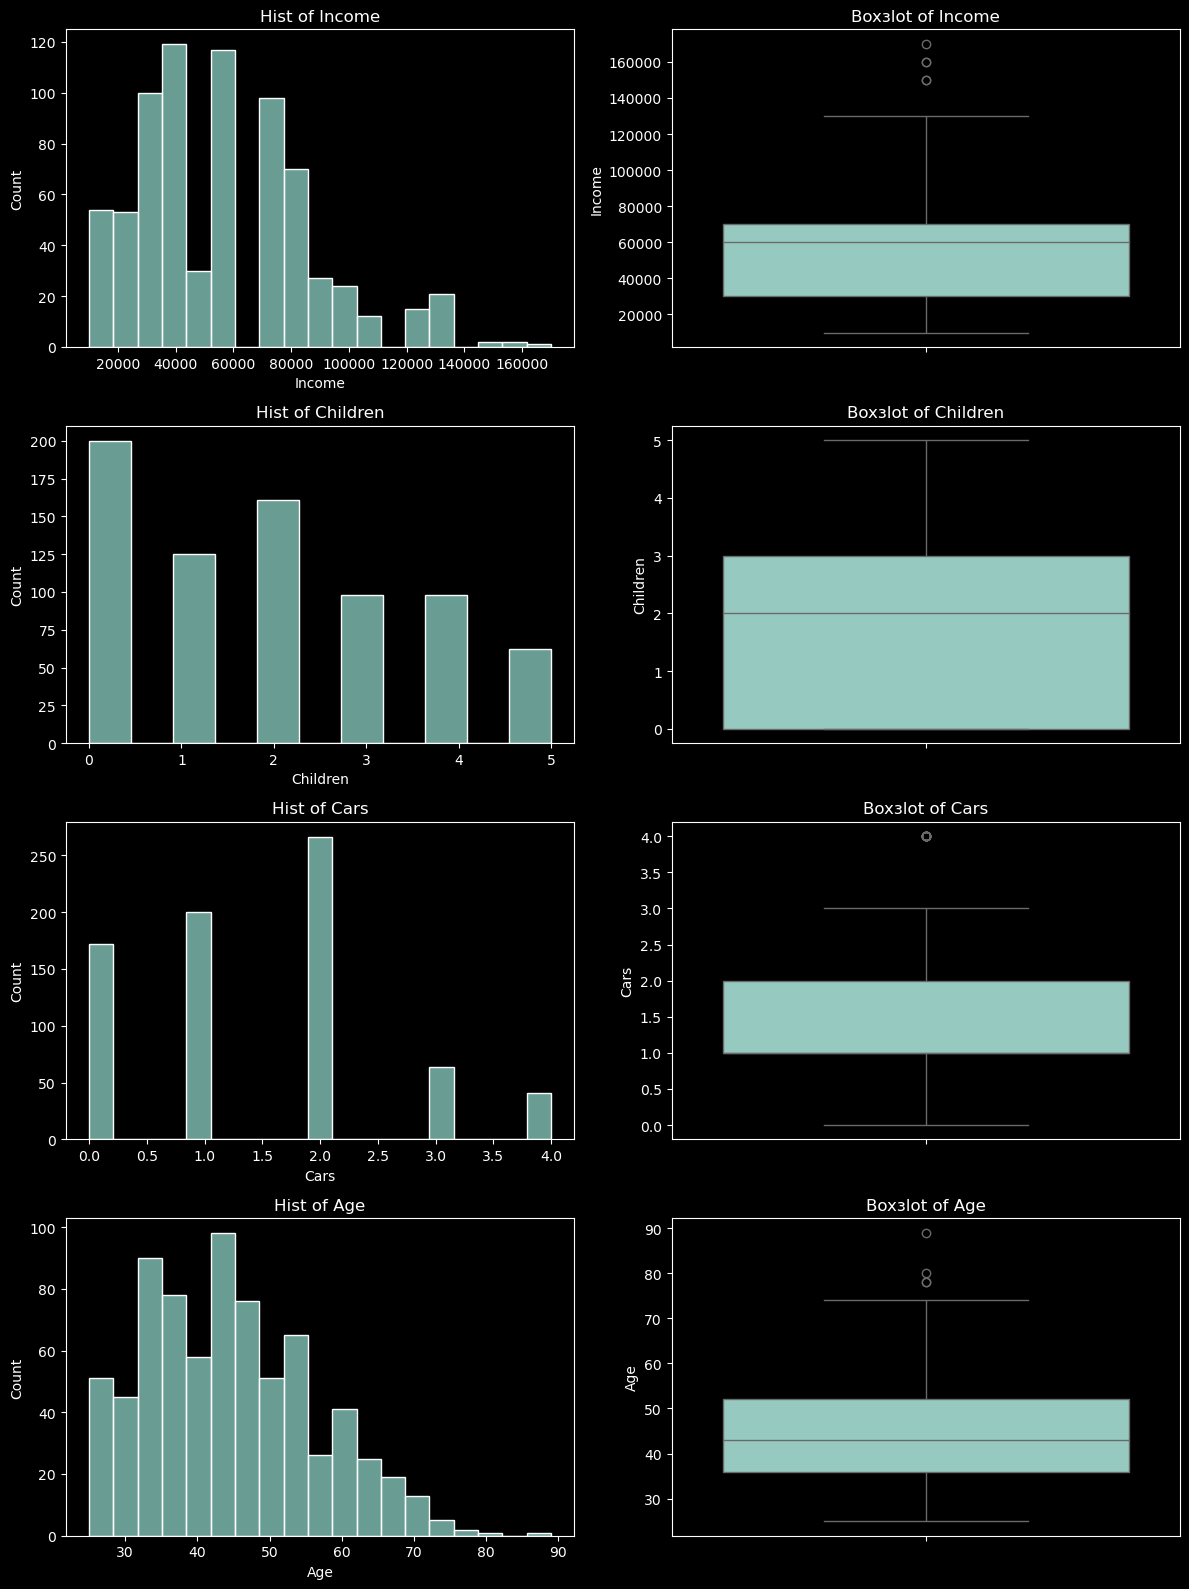

In [168]:
numeric = ['Income', 'Children', 'Cars', 'Age']
n = len(numeric)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))

for i, feature in enumerate(numeric):
    sns.histplot(X_train[feature], ax=axes[i, 0])
    axes[i, 0].set_title(f'Hist of {feature}')
    sns.boxplot(y=X_train[feature], ax=axes[i, 1])  
    axes[i, 1].set_title(f'Boxзlot of {feature}')

plt.tight_layout()  
plt.show()

Выбросы есть в признаках: возраст, доход, ну и выпадает значение для cars = 4. Теперь посмотрим на пропуски и заполним их медианой

In [275]:
X_train[['Income', 'Children', 'Cars', 'Age']] = X_train[['Income', 'Children', 'Cars', 'Age']].fillna(X[['Income', 'Children', 'Cars', 'Age']].median())
X_test[['Income', 'Children', 'Cars', 'Age']] = X_test[['Income', 'Children', 'Cars', 'Age']].fillna(X[['Income', 'Children', 'Cars', 'Age']].median())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [276]:
for feature in ['Income', 'Children', 'Cars', 'Age']:
    print(f'{feature}: {len(X[feature].unique())}')

Income: 17
Children: 7
Cars: 6
Age: 54


In [277]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_train = pd.Series(y_train)
X_train = pd.DataFrame(X_train)

In [278]:
class SmoothMeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features, C=10):
        super().__init__()
        self.mte_map = {}
        self.features = features
        self.C = C
        self.global_mean = 0

    def fit(self, X, y):
        Xy = pd.concat((X, y), axis=1).rename(columns={y.name: "target"})
        Xy = pd.DataFrame(Xy)
        self.global_mean = np.mean(y)
        for feature in self.features:
            pos = Xy.groupby(feature)["target"].sum() + self.C * self.global_mean
            self.mte_map[feature] = pos * 1.0 / (Xy.groupby(feature)["target"].count() + self.C)
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature] = X[feature].map(self.mte_map[feature])
            X[feature] = X[feature].fillna(self.global_mean)
        return X

In [291]:
from sklearn.preprocessing import StandardScaler

categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
numeric = ['Income', 'Children', 'Cars', 'Age']

column_transformer = ColumnTransformer([
        ('mte', SmoothMeanTargetEncoder(categorical, -10), categorical),
        ('mte2', SmoothMeanTargetEncoder(numeric, 15), numeric)
])

pipeline = Pipeline(steps=[
        ('transformer', column_transformer),
        ('logistic_regression', LogisticRegression())
])

X_train = pd.DataFrame(X_train)
model = LogisticRegression(max_iter=1000)
model = pipeline.fit(pd.DataFrame(X_train), y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"auc_roc_test: {roc_auc_score(y_test, y_pred)}")

auc_roc_test: 0.7103205128205129


*Стало лучше! самый высокий результат получился*

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 
Плюсы:
1) конечно, получается меньше признаков в итоге, а еще они интерпретируемы в отличие от n закодированных ohe признаков
2) счетчики позволяют (судя по качеству) уловить больше зависимостей с таргетом

Минусы:
1) качество на трейне и тесте может достаточно сильно отличаться, то есть сильнее зависят от конкретных данных 
2) не учитывают порядок в категориальных данных

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [184]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-02 18:19:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.4’

adult.data.4            [                 <=>]   3,79M   989KB/s    in 3,9s    

2024-12-02 18:19:07 (989 KB/s) - ‘adult.data.4’ saved [3974305]



In [185]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
11376,62,Federal-gov,209433,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [186]:
y = df['income']
X = df.loc[:, ~df.columns.isin(['income'])]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [187]:
from sklearn.preprocessing import StandardScaler

numeric = [
    'fnlwgt', 'education-num',
    'capital-gain', 'capital-loss', 'hours-per-week', 'age'
]
categorical = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race', 'sex',
    'native-country'
]
column_transformer = ColumnTransformer([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

train = column_transformer.fit_transform(X_train, y_train)
test = column_transformer.transform(X_test)

print(f'X_train shape: {X_train.shape}')
print(f'X_train shape after one-hot-encoding: {train.shape}')
print(f'New features: {train.shape[1] - X_train.shape[1]}')

X_train shape: (24420, 14)
X_train shape after one-hot-encoding: (24420, 108)
New features: 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [188]:
logreg = LogisticRegression()
logreg.fit(train, y_train)
y_pred_prob = logreg.predict_proba(test)[:, 1]
auc_pr_test = average_precision_score(y_test, y_pred_prob)
print(f"AUC-PR test: {auc_pr_test}")

AUC-PR test: 0.7672340764944497


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [189]:
X_valid, X_train, y_valid, y_train = train_test_split(X_train, y_train, test_size=0.5, random_state=777)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [190]:
start = time.time()
train = column_transformer.fit_transform(X_train, y_train)
test = column_transformer.transform(X_test)

logreg = LogisticRegression()
logreg.fit(train, y_train)
coef = np.abs(logreg.coef_[0])
top_feature_indices_base = np.argsort(coef)[-40:]
train_selected = train[:, top_feature_indices_base]
test_selected = test[:, top_feature_indices_base]
end = time.time()

print(f'time spent: {end-start}')
print(test_selected.shape, train_selected.shape)
logreg = LogisticRegression()
logreg.fit(train_selected, y_train)
y_pred_prob = logreg.predict_proba(test_selected)[:, 1]
print(f"AUC-PR test: {average_precision_score(y_test, y_pred_prob)}")

time spent: 0.08187317848205566
(8141, 40) (12210, 40)
AUC-PR test: 0.7327338783995428


Изменилось ли качество? Как? 

Вообще, стало немного похуже, но не сильно

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

*Делала нормирование сразу, так что попробуем без*

In [191]:
column_transformer = ColumnTransformer([
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore'), categorical)
])
train = column_transformer.fit_transform(X_train, y_train)
test = column_transformer.transform(X_test)

logreg = LogisticRegression()
logreg.fit(train, y_train)
y_pred_prob = logreg.predict_proba(test)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_prob)
print(f"AUC-PR test: {auc_pr}")

coef = np.abs(logreg.coef_[0])
top_feature_indices_without_scale = np.argsort(coef)[-40:]
train_selected = train[:, top_feature_indices_without_scale]
test_selected = test[:, top_feature_indices_without_scale]
print(test_selected.shape, train_selected.shape)
logreg = LogisticRegression()
logreg.fit(train_selected, y_train)
y_pred_prob = logreg.predict_proba(test_selected)[:, 1]
print(f"AUC-PR test: {average_precision_score(y_test, y_pred_prob)}")

AUC-PR test: 0.6832455839320498
(8141, 40) (12210, 40)
AUC-PR test: 0.6502946265550014


*Качество очевидно упало (причем и без отбора, а с ним еще побольше)*

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [192]:
col_transformer = ColumnTransformer([
    ('one_hot_encoding', OneHotEncoder(sparse_output=False), categorical),
    ('scaling', StandardScaler(), numeric)
])

train = col_transformer.fit_transform(X_train, y_train)
test = col_transformer.transform(X_test)

scale_transformer = ColumnTransformer([
     ('scaling', StandardScaler(), pd.DataFrame(train).columns)
])

train_s = scale_transformer.fit_transform(pd.DataFrame(train), y_train)
test_s = scale_transformer.transform(pd.DataFrame(test))

logreg = LogisticRegression()
logreg.fit(train_s, y_train)
y_pred_prob = logreg.predict_proba(test_s)[:, 1]
print(f"AUC-PR test: {average_precision_score(y_test, y_pred_prob)}")

coef = np.abs(logreg.coef_[0])
top_feature_indices_with_scale_double = np.argsort(coef)[-40:]
train_selected = train[:, top_feature_indices_with_scale_double]
test_selected = test[:, top_feature_indices_with_scale_double]

logreg = LogisticRegression()
logreg.fit(train_selected, y_train)
y_pred_prob = logreg.predict_proba(test_selected)[:, 1]
print(f"AUC-PR test: {average_precision_score(y_test, y_pred_prob)}")

AUC-PR test: 0.7630913716507339
AUC-PR test: 0.7568079931422893


*качество выросло, по сравнению со случаем без использования второй нормировки*

*сравним отобранные 40 признаков с набором для нормирования + onehot*

In [193]:
top_feature_indices_base = np.array(top_feature_indices_base)
top_feature_indices_with_scale_double = np.array(top_feature_indices_with_scale_double)
print(f'Num of same features: {len(np.intersect1d(top_feature_indices_base,top_feature_indices_with_scale_double))}')

Num of same features: 25


*получается, наборы совпадают примерно на 60%*

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** корреляция показывает только линейную зависимость между таргетом и признаком - то есть корреляция близкая к 1 (по модулю) может быть полезной для предсказательной способности модели, однако признаки с небольшим значением тоже могут быть полезны, тк могут иметь нелинейную зависимость с таргетом. Вероятно, лучше всего объединять признаки, хорошо скоррелированные с таргетом, с теми, которые имеют другой характер зависимости

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [194]:
start = time.time()
corr = pd.DataFrame(train).corrwith(y_train)
abs_corr = np.abs(corr) 
abs_corr = abs_corr.dropna()
top_feature_indices_corr = np.argsort(abs_corr)[-40:] 
train_selected = train[:, top_feature_indices_corr]
test_selected = test[:, top_feature_indices_corr]
end = time.time()

logreg = LogisticRegression()
logreg.fit(train_selected, y_train)
y_pred_prob = logreg.predict_proba(test_selected)[:, 1]
print(f'time spent: {end-start}')
print(f"AUC-PR test: {average_precision_score(y_test, y_pred_prob)}")

time spent: 0.07982182502746582
AUC-PR test: 0.7270195579895733


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [195]:
def tt_stat(train, y_train):
    y_train.reset_index(drop=True, inplace=True)
    positive = y_train[y_train > 0].index
    negative = y_train[y_train == 0].index
    t_statistics = []
    train = pd.DataFrame(train)
    for col in train.columns:
        pos_data = train.loc[positive, col]
        neg_data = train.loc[negative, col]
        n_pos = pos_data.shape[0]
        n_neg = neg_data.shape[0]
        mean_pos = pos_data.mean()
        mean_neg = neg_data.mean()
        var_pos = pos_data.std()
        var_neg = neg_data.std()
        if var_pos == 0 and var_neg ==0:
            t = 0
        else:
            t = np.abs((mean_pos - mean_neg)) / np.sqrt((n_pos * var_pos**2 + n_neg * var_neg**2)/(n_pos + n_neg))
            t_statistics.append(t)
    return t_statistics

In [196]:
start = time.time()
t_statistics = tt_stat(train, y_train)
top_feature_indices_t = np.argsort(t_statistics)[-40:] 
train_selected = pd.DataFrame(train).iloc[:, top_feature_indices_t]
test_selected = pd.DataFrame(test).iloc[:, top_feature_indices_t]
end = time.time()

logreg = LogisticRegression()
logreg.fit(train_selected, y_train)
y_pred_prob = logreg.predict_proba(test_selected)[:, 1]
print(f'time spent: {end-start}')
print(f"AUC-PR test: {average_precision_score(y_test, y_pred_prob)}")

time spent: 0.05926990509033203
AUC-PR test: 0.7584448109349279


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

*имеет смысл подбирать длину шага из соображений того, что слишком большой шаг дедает подбор хуже*

In [197]:
import time

In [201]:
def select_features(train, y_train, n = 40, step_size=5):
    cur = set(train.columns)
    num_features = len(cur)
    removed = set()
    start_time = time.time()
    while num_features > n:
        model = LogisticRegression(max_iter=1000)
        train_cur = train[list(cur)]
        model.fit(train[list(cur)], y_train)
        coef = np.abs(model.coef_[0])
        feature_importance = dict(zip(cur, coef))
        to_remove = sorted(feature_importance.items(), key=lambda x: x[1])[:min(step_size, num_features - n)]
        removed.update([x[0] for x in to_remove])
        cur -= set([x[0] for x in to_remove])
        num_features = len(cur)
        print(f'Features in train: {num_features}\n Score on train:{average_precision_score(y_train, model.predict_proba(train_cur)[:, 1])}\n')
    end_time = time.time()
    return list(cur), end_time - start_time

def evaluate(train, y_train, test, y_test, feature_indices):
    train_selected = pd.DataFrame(train).iloc[:, feature_indices]
    test_selected = pd.DataFrame(test).iloc[:, feature_indices]
    model = LogisticRegression()
    model.fit(train_selected, y_train)
    y_pred_prob = model.predict_proba(test_selected)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred_prob)
    return auc_pr

In [202]:
step_size = 3
selected_features, time_spent = select_features(pd.DataFrame(train), y_train, step_size=step_size)
auc_pr_ = evaluate(train, y_train, test, y_test, selected_features)

Features in train: 104
 Score on train:0.7703331003256674

Features in train: 101
 Score on train:0.7702878859221135

Features in train: 98
 Score on train:0.7703517901596293

Features in train: 95
 Score on train:0.770229415684496

Features in train: 92
 Score on train:0.7702790589256783

Features in train: 89
 Score on train:0.7699982097978209

Features in train: 86
 Score on train:0.7700532341760404

Features in train: 83
 Score on train:0.769976295395565

Features in train: 80
 Score on train:0.7699306327258033

Features in train: 77
 Score on train:0.7699323082296945

Features in train: 74
 Score on train:0.7698994709850916

Features in train: 71
 Score on train:0.7698678505408965

Features in train: 68
 Score on train:0.7696712765557352

Features in train: 65
 Score on train:0.7696235787057157

Features in train: 62
 Score on train:0.7695645764630473

Features in train: 59
 Score on train:0.7695045496177241

Features in train: 56
 Score on train:0.7695745504500355

Features in tr

In [203]:
print(f"AUC-PR test: {auc_pr_}")
print(f"time spent: {time_spent:.4f}")

AUC-PR test: 0.753517133173723
time spent: 2.5956


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [207]:
train = pd.DataFrame(train)
model_lr = LogisticRegression(max_iter=1000)
cur = []
features = []

start_time = time.time()
while len(cur) < 40:
    max_score, best_f = 0.0, -1
    for i, feature in enumerate(train.columns):
        if feature not in cur:
            temp = cur + [feature]
            model_lr.fit(train.iloc[:, temp], y_train)
            train_predict = model_lr.predict_proba(pd.DataFrame(train).iloc[:, temp])[:, 1]
            cur_score = average_precision_score(y_train, train_predict)
            if max_score < cur_score:
                max_score = cur_score
                best_f = feature

    cur.append(best_f)
    features.append(best_f)
    print(f'Features in train: {len(cur)}\n Score on train:{cur_score}\n')

end_time = time.time()

Features in train: 1
 Score on train:0.3264892758800617

Features in train: 2
 Score on train:0.5067438295373197

Features in train: 3
 Score on train:0.6387429552699444

Features in train: 4
 Score on train:0.7203002942111144

Features in train: 5
 Score on train:0.7284057586549921

Features in train: 6
 Score on train:0.7382737513159114

Features in train: 7
 Score on train:0.746501051423915

Features in train: 8
 Score on train:0.74695451261119

Features in train: 9
 Score on train:0.7503772200311601

Features in train: 10
 Score on train:0.7529467888527552

Features in train: 11
 Score on train:0.7548546670265102

Features in train: 12
 Score on train:0.7566975034434827

Features in train: 13
 Score on train:0.7577206031328133

Features in train: 14
 Score on train:0.7587242790041424

Features in train: 15
 Score on train:0.7595078533957299

Features in train: 16
 Score on train:0.7601790651052652

Features in train: 17
 Score on train:0.7608119315712436

Features in train: 18
 Sco

In [208]:

train_selected = train.iloc[:, features]
test_selected = pd.DataFrame(test).iloc[:, features]
model = LogisticRegression()
model.fit(train_selected, y_train)
y_pred_prob = model.predict_proba(test_selected)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_prob)

print(f"AUC-PR test: {auc_pr}")
print(f"time spent: {end_time - start_time:.4f}")

AUC-PR test: 0.7640742602477005
time spent: 123.2463


*вот это наконец-то победа*

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
1) Очевидным образом лучше на самих данных использовать нормировку для числовых и ohe для категориальных
2) Встроенные методы: лучше всего по качеству на тесте работает нормировка поверх one-hot, и последующих отбор 40 (но ниже, чем бенчмарк)
3) Методы фильтрации: корреляция дает результат хуже, чем встроенные методы, а вот т-статистика (около 0.75) уже приблизилась к бенчмарку 
4) Методы обертки: при убирании признаков получаем результат близкий к т-статистике, а вот при добавлении признаков наконец то получилось лучше, чем изначально (0.77)

Про время работы: методы фильтрации работают сильно быстрее методов обертки, а добавление признаков самое долгое, но дает наилучший прирост качества

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [209]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-02 18:28:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.1’

bank-additional.zip     [         <=>        ] 434,15K   236KB/s    in 1,8s    

2024-12-02 18:28:26 (236 KB/s) - ‘bank-additional.zip.1’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [296]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [297]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [298]:
df.drop(columns = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], inplace=True)

In [299]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [331]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score, precision_recall_curve

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=777,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        numeric = X_train.select_dtypes(include=np.number).columns
        categorical = X_train.select_dtypes(include=object).columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
            ])
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression())
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict_proba(X_test)[:, 1]
        score = average_precision_score(y_test, y_pred)
        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            "score": score
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [332]:
metric = cross_validate(X, y)
print(metric)

      score
0  0.430425
1  0.368656
2  0.390947
3  0.385718
4  0.434789


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [339]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=777,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    for train_index, test_index in kf.split(X):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        numeric = X_train.select_dtypes(include=np.number).columns
        categorical = X_train.select_dtypes(include=object).columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
            ])
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression())
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_p = pipeline.predict_proba(X_test)[:, 1]
        score = average_precision_score(y_test, y_pred_p)

        revenue = 10 * ((y_pred == 1) & (y_pred == y_test)).sum()
        profit = revenue - y_pred.sum()*2
        metric_dict = {
            "score": score,
            "revenue" : revenue,
            "profit" : profit
        }
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

In [340]:
results = cross_validate(X, y)
print(results)

average_profit = results['profit'].mean()
std_profit = results['profit'].std()
operator_cost = (results['revenue'] - results['profit']).mean()

print(f"\naverage profit: ${average_profit:.2f}\n")
print(f"std of profit: ${std_profit:.2f}\n")
print(f"operator cost: ${operator_cost:.2f}\n")

      score  revenue  profit
0  0.430425     1720    1252
1  0.368656     1620    1106
2  0.390947     1730    1154
3  0.385718     1650    1118
4  0.434789     1910    1350

average profit: $1196.00

std of profit: $103.44

operator cost: $530.00



*Бизнес метрика действительно прямо пропорциальна скору*

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [347]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=777,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        numeric = X_train.select_dtypes(include=np.number).columns
        categorical = X_train.select_dtypes(include=object).columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
            ])
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression())
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_p = pipeline.predict_proba(X_test)[:, 1]
        score = average_precision_score(y_test, y_pred_p)

        revenue = ((y_pred == 1) & (y_pred == y_test)).sum()
        cost = np.random.uniform(0, 20, 1)[0]
        revenue *= cost 
        profit = revenue - y_pred.sum() * 2 
        metric_dict = {
            "score": score,
            "revenue" : revenue,
            "profit" : profit
        }
        metrics.append(metric_dict)
    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

In [348]:
results = cross_validate(X, y)
print(results)

average_profit = results['profit'].mean()
std_profit = results['profit'].std()
operator_cost = (results['revenue'] - results['profit']).mean()

print(f"\naverage profit: ${average_profit:.2f}\n")
print(f"std of profit: ${std_profit:.2f}\n")
print(f"operator cost: ${operator_cost:.2f}\n")

      score      revenue       profit
0  0.430425  2312.401132  1844.401132
1  0.368656   651.406300   137.406300
2  0.390947  2690.781698  2114.781698
3  0.385718  1693.067534  1161.067534
4  0.434789  2218.017607  1658.017607

average profit: $1383.13

std of profit: $778.59

operator cost: $530.00



очевидным образом выросло стандартное отклонение, и немного выросло среднее (но в целом очень близко к оригинальному значению)

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [349]:
from sklearn.model_selection import ParameterGrid
def cross_validate(X, y, n_splits=5, random_state=777, C=1.0):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        numeric = X_train.select_dtypes(include=np.number).columns
        categorical = X_train.select_dtypes(include=object).columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
            ])
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(C=C, random_state=random_state)) 
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_p = pipeline.predict_proba(X_test)[:, 1]
        score = average_precision_score(y_test, y_pred_p)

        revenue = ((y_pred == 1) & (y_pred == y_test)).sum() 
        cost = np.random.uniform(0, 20, 1)[0]
        revenue *= cost
        profit = revenue - y_pred.sum() * 2 
        metric_dict = {
            "score": score,
            "revenue": revenue,
            "profit": profit
        }
        metrics.append(metric_dict)
    return pd.DataFrame(metrics).mean()

In [354]:
param_grid = {'C': np.logspace(-3, 5, 20)} 
grid_search = ParameterGrid(param_grid)

results = []
for params in grid_search:
    result = cross_validate(X, y, C=params['C'])
    result['C'] = params['C']
    results.append(result)

results_df = pd.DataFrame(results)

best_C = results_df.loc[results_df['profit'].idxmax(), 'C']
max_profit = results_df['profit'].max()

print(f"max profit: {max_profit:.2f}, C = {best_C:.2f}")

max profit: 2039.20, C = 42.81


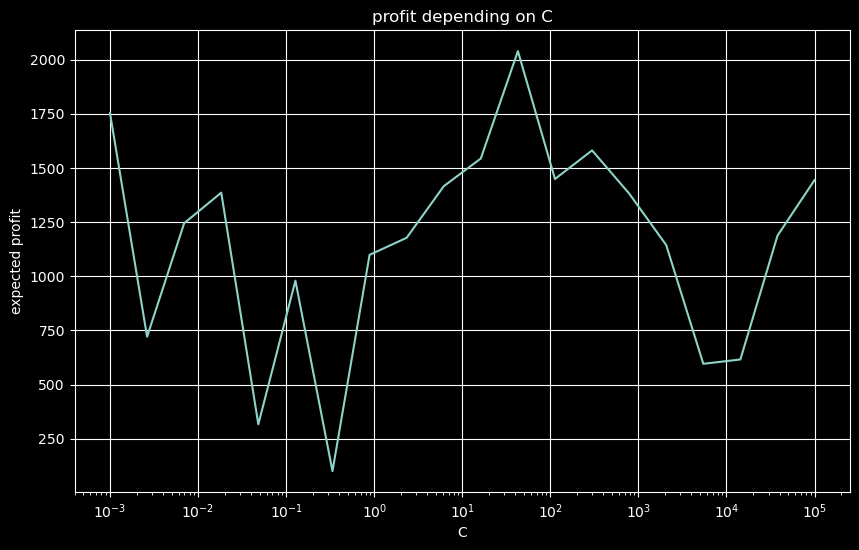

In [355]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['C'], results_df['profit'])
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('expected profit')
plt.title('profit depending on C')
plt.grid(True)
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [356]:
param_grid = {'C': np.logspace(-2, 5, 20)}
grid_search = ParameterGrid(param_grid)

n_runs = 10 
best_Cs = []
max_profits = []
for run in range(n_runs):
    print(f"{run+1} out of {n_runs}")
    np.random.seed(run)  
    results = []
    for params in grid_search:
        result = cross_validate(X, y, C=params['C'])
        result['C'] = params['C']
        results.append(result)

    results_df = pd.DataFrame(results)
    best_C = results_df.loc[results_df['profit'].idxmax(), 'C']
    max_profit = results_df['profit'].max()
    best_Cs.append(best_C)
    max_profits.append(max_profit)
    print(f"max profit: {max_profit:.2f}, C = {best_C:.2f}")

1 out of 10
max profit: 2087.71, C = 1438.45
2 out of 10
max profit: 1984.95, C = 0.30
3 out of 10
max profit: 1737.33, C = 8.86
4 out of 10
max profit: 2049.14, C = 1.62
5 out of 10
max profit: 2163.28, C = 0.01
6 out of 10
max profit: 2307.03, C = 263.67
7 out of 10
max profit: 2143.24, C = 0.13
8 out of 10
max profit: 1831.01, C = 615.85
9 out of 10
max profit: 1963.18, C = 18329.81
10 out of 10
max profit: 1847.88, C = 0.70


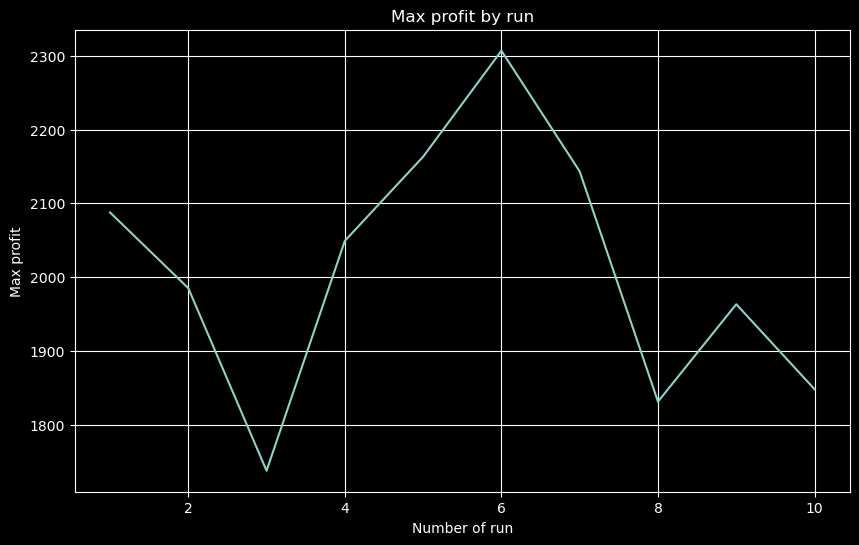

In [359]:
plt.figure(figsize=(10,6))
plt.plot(range(1,n_runs+1), max_profits)
plt.xlabel("Number of run")
plt.ylabel("Max profit")
plt.title("Max profit by run")
plt.grid(True)
plt.show()

В силу того, что прибыль мы считаем с учетом некоторой доли случайности, лучшие С каждый раз получается разный, однако находится в большинстве случаев в близком диапазоне. Вообще как можно заметить по графикам, мы видимо очень подвержены рандому. Если говорить про значение максимальной прибыли, то ее значение имеет как раз небольшой разброс, в отличие от С

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Вероятно, важнее все-таки precision. При высоком precision модель делает меньше ложноположительных предсказаний, а в нашей модели они приводят к затратам (тратим ресурсы на клиентов, которые не принесут прибыль). Recall влияет на потенциальный доход, но не так критично: высокий recall означает, что мы правильно идентифицируем большое количество истинных положительных случаев. Однако сли precision низкий, то высокий recall приведёт к большим затратам



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [362]:
from sklearn.metrics import average_precision_score, precision_score, recall_score

def cross_validate(X, y, n_splits=5, random_state=777, C=1.0, threshold=0.5):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        numeric = X_train.select_dtypes(include=np.number).columns
        categorical = X_train.select_dtypes(include=object).columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
            ])
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(C=C, random_state=random_state))
        ])
        pipeline.fit(X_train, y_train)
        y_pred_p = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_p >= threshold).astype(int) 
        score = average_precision_score(y_test, y_pred_p)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        revenue = ((y_pred == 1) & (y_pred == y_test)).sum() * np.random.normal(10, 2, 1)[0]
        profit = revenue - y_pred.sum() * 5
        metric_dict = {
            "score": score,
            "revenue": revenue,
            "profit": profit,
            "precision": precision,
            "recall": recall,
            "threshold": threshold
        }
        metrics.append(metric_dict)
    return pd.DataFrame(metrics).mean()

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

ModuleNotFoundError: No module named 'kagglehub'

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here